#### CIRCULAR PROBLEM OF DEPENDECIES - NOT CONTINUING: https://github.com/jdb78/pytorch-forecasting/issues/1256

In [1]:
#python libraries
import os
import re
import copy
from pathlib import Path
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths


#other ML libraries
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
from pytorch_forecasting import Baseline, NBeats, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import MultiNormalizer, GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

#ploting
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Setting random seeds for reproducibility
random_seed = 420
np.random.seed(random_seed)
_ = torch.manual_seed(random_seed)

### DATA CLEANING

In [3]:
#Import Disruptive & Netatmo Sensor Data

# assign variables
directory = './storedData/'
sensor_data = pd.DataFrame()
sensor_data['timestamp'] = None #in order to merge based on it 

measurement_types = ["Door", "Water", "Humidity_temperature", "Humidity_humidity", 
                     "Humidifier_humidity", "Humidifier_temperature","Temperature",
                     "Hum_temperature", "Hum_humidity"]
discrete_measurement_types = ["Door", "Water"]


# iterate over files in that directory and concat into 1 big dataframe based on timestamps
for filename in os.listdir(directory): 
    file = os.path.join(directory, filename)
    if os.path.isfile(file):    
        df = pd.read_csv(file)
        df.drop(columns=df.columns[0], inplace=True) # dropping unnamed coloumn for indexing in .cvs file

        df['timestamp'] = pd.to_datetime(df['timestamp'],  utc=True)#.dt.tz_convert('Europe/Rome') #set timezone correctly if not correct in local time
        df.set_index("timestamp", inplace=True)
        for measurement_name in df.columns:
            measurement_frame = df[measurement_name].to_frame()

            measurement_name_list = re.findall("([A-Z0-9][^A-Z]*)", measurement_name) # Splitting string on capital letters
            measurement_type = measurement_name_list[-1]
            if measurement_type not in measurement_types: #Temperature measurements does not have temperature in their name
                measurement_type = "Temperature"
                measurement_name_list.append(measurement_type)
            #Renaming coloumn for consistent naming
            coloumn_name = f"{''.join(measurement_name_list[:-1])}_{measurement_type.lower()}"
            measurement_frame.rename(columns={measurement_frame.columns[0]: coloumn_name}, inplace=True)
            # print(f"key: {measurement_frame.columns[0]} Value: {coloumn_name}")
            if measurement_type in discrete_measurement_types:
                #For Water Detection:
                #NOT_PRESENT == No water detected = 0
                #PRESENT     == water detected    = 1

                #For Door Sensors: - this is because sensor changes state based on if it detects objects in front of it
                #NOT_PRESENT == DOOR IS OPEN     = 0
                #PRESENT     == DOOR IS CLOSED   = 1
                
                # measurement_frame.replace(['NOT_PRESENT', 'PRESENT'],[0, 1], inplace=True)
                measurement_frame = measurement_frame.resample('15T').ffill()
            else: #Contious measurement
                measurement_frame  = measurement_frame.resample('15T').mean().interpolate() #Resample to managable timestamps by taking mean of 5 minute slots and linear interpolating NaNs, i.e. 5, 10, 15, 20 minutes etc..

    
            sensor_data = pd.merge(sensor_data, measurement_frame, on='timestamp', how="outer")  

sensor_data.set_index("timestamp", inplace=True)
sensor_data.sort_index(axis=0, inplace=True) #Sorting by timestamp
sensor_data.sort_index(axis=1, inplace=True) #Sorting columns alpabetically

#Postprocesing the data in order to get rid of the NaN Values
#ffill and fillna(0/1) to populate NaN values of the proximity with ffill and then set the values before first valid value to DOOR_CLOSED/NO_WATER
sensor_data.loc[:, sensor_data.columns.str.endswith('door')] = sensor_data.loc[:, sensor_data.columns.str.endswith('door')].ffill().fillna('PRESENT')
sensor_data.loc[:, sensor_data.columns.str.endswith('water')] = sensor_data.loc[:, sensor_data.columns.str.endswith('water')].ffill().fillna('NOT_PRESENT')


# # #linearly interpolate temperature and humidity values:
sensor_data.loc[:, sensor_data.columns.str.endswith('temperature')]  = sensor_data.loc[:, sensor_data.columns.str.endswith('temperature')].interpolate().bfill().ffill()
sensor_data.loc[:, sensor_data.columns.str.endswith('humidity')]  = sensor_data.loc[:, sensor_data.columns.str.endswith('humidity')].interpolate().bfill().ffill()

### FEATURE ENGINEERING ###

In [4]:
#Add hand-designed time-of-day and day-of-year features
min_in_hour = 60
min_in_day = 24*min_in_hour
sensor_data['sin_daily'] = np.sin(2*np.pi*(sensor_data.index.minute + sensor_data.index.hour*min_in_hour)/min_in_day).values
sensor_data['cos_daily'] = np.cos(2*np.pi*(sensor_data.index.minute + sensor_data.index.hour*min_in_hour)/min_in_day).values

days_in_year = 365.2425
sensor_data['sin_yearly'] = np.sin(2*np.pi*(sensor_data.index.day_of_year)/days_in_year).values
sensor_data['cos_yearly'] = np.cos(2*np.pi*(sensor_data.index.day_of_year)/days_in_year).values

days_in_week = 7
sensor_data['sin_weekly'] = np.sin(2*np.pi*(sensor_data.index.day_of_week)/days_in_week).values
sensor_data['cos_weekly'] = np.cos(2*np.pi*(sensor_data.index.day_of_week)/days_in_week).values

In [5]:
sensor_data.describe()

,0BRoom_temperature,0BTCeiling_temperature,0BTFloor_temperature,1Entrance1_temperature,1GuestRoom_temperature,1MainBR_hum_humidity,1MainBR_hum_temperature,1MainRoom_temperature,1OutdoorEntrance_temperature,1StairBottom_temperature,...,2LivingRoom_humidifier_humidity,2LivingRoom_humidifier_temperature,2OfficeDesk_temperature,2Stair_temperature,sin_daily,cos_daily,sin_yearly,cos_yearly,sin_weekly,cos_weekly
count,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,...,39166.000000,39166.000000,39166.000000,39166.000000,3.916600e+04,3.916600e+04,39166.000000,39166.000000,39166.000000,39166.000000
mean,20.219920,20.493444,19.880145,23.061776,18.888458,38.371860,18.992936,18.256772,7.109260,20.844034,...,36.970944,21.596080,20.351772,21.664779,4.776617e-05,-1.797791e-05,0.048966,0.089977,-0.004115,0.000289
std,2.777353,2.358416,2.570392,1.703731,3.133083,9.052182,2.767227,3.078381,6.918604,1.572467,...,7.815859,2.549447,3.360557,2.543805,7.071023e-01,7.071294e-01,0.686751,0.719656,0.707943,0.706275
min,10.250000,15.100000,14.150000,15.300000,5.700000,19.000000,4.900000,3.200000,-14.650000,13.566667,...,21.000000,10.550000,10.525000,10.950000,-1.000000e+00,-1.000000e+00,-0.999999,-0.999979,-0.974928,-0.900969
25%,18.800000,18.750000,18.050000,22.300000,17.650000,31.000000,17.800000,16.800000,2.050000,20.033333,...,31.000000,20.100000,18.383333,20.250000,-7.071068e-01,-7.071068e-01,-0.639648,-0.641690,-0.781831,-0.900969
50%,20.200000,20.483333,19.750000,23.450000,19.200000,37.000000,19.350000,18.600000,6.300000,21.033333,...,36.000000,21.550000,20.200000,21.583333,1.224647e-16,-1.836970e-16,0.164758,0.176443,0.000000,-0.222521
75%,22.000000,22.100000,21.650000,24.250000,20.925000,45.000000,20.700000,20.200000,11.800000,21.866667,...,43.000000,23.300000,22.366667,23.116667,7.071068e-01,7.071068e-01,0.681936,0.811856,0.781831,0.623490
max,27.450000,31.550000,27.750000,26.900000,28.200000,67.000000,27.300000,27.450000,32.500000,25.400000,...,61.000000,30.700000,32.425000,30.000000,1.000000e+00,1.000000e+00,0.999986,0.999991,0.974928,1.000000


### DATA PREPROCESSING

In [6]:
data = sensor_data.copy()
cols_to_drop = ['1MainBR_hum_temperature', '2BalconyEntrance_temperature', '2LRWindow_temperature',
                '2LivingRoomCenter_humidity_temperature', '2LivingRoom_humidifier_temperature'] #due to correlation
data = data.drop(cols_to_drop, axis=1)

drop_hum_and_water_data = True
if drop_hum_and_water_data:
    data = data.drop(data.columns[data.columns.str.endswith('humidity')], axis=1)
    data = data.drop(data.columns[data.columns.str.endswith('water')], axis=1)

data = data.reset_index()
data['time_idx'] = data.index

In [7]:
data

,timestamp,0BGuest_door,0BRoom_temperature,0BTCeiling_temperature,0BTFloor_temperature,0B_door,1Entrance1_temperature,1GuestRoom_temperature,1MainRoom_temperature,1Main_door,...,2OfficeDesk_temperature,2Office_door,2Stair_temperature,sin_daily,cos_daily,sin_yearly,cos_yearly,sin_weekly,cos_weekly,time_idx
0,2022-01-07 19:45:00+00:00,PRESENT,16.20,18.675000,19.50,PRESENT,21.20,16.25,14.900,PRESENT,...,19.775000,PRESENT,21.150000,-0.896873,4.422887e-01,0.120129,0.992758,-0.433884,-0.900969,0
1,2022-01-07 20:00:00+00:00,PRESENT,16.20,18.700000,19.60,PRESENT,21.15,16.35,15.075,PRESENT,...,19.733333,PRESENT,21.000000,-0.866025,5.000000e-01,0.120129,0.992758,-0.433884,-0.900969,1
2,2022-01-07 20:15:00+00:00,NOT_PRESENT,16.40,18.866667,19.70,NOT_PRESENT,21.10,16.40,15.250,PRESENT,...,19.525000,PRESENT,20.800000,-0.831470,5.555702e-01,0.120129,0.992758,-0.433884,-0.900969,2
3,2022-01-07 20:30:00+00:00,NOT_PRESENT,16.80,19.000000,19.75,NOT_PRESENT,21.10,16.50,15.300,PRESENT,...,19.350000,PRESENT,20.583333,-0.793353,6.087614e-01,0.120129,0.992758,-0.433884,-0.900969,3
4,2022-01-07 20:45:00+00:00,NOT_PRESENT,17.25,19.100000,19.80,NOT_PRESENT,21.10,16.60,15.400,PRESENT,...,20.066667,PRESENT,20.425000,-0.751840,6.593458e-01,0.120129,0.992758,-0.433884,-0.900969,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39161,2023-02-19 18:00:00+00:00,PRESENT,17.20,22.683333,22.55,NOT_PRESENT,24.50,21.75,15.700,PRESENT,...,16.800000,PRESENT,24.925000,-1.000000,-1.836970e-16,0.757933,0.652332,-0.781831,0.623490,39161
39162,2023-02-19 18:15:00+00:00,PRESENT,17.15,22.925000,22.95,PRESENT,24.35,21.70,16.250,PRESENT,...,16.800000,PRESENT,24.800000,-0.997859,6.540313e-02,0.757933,0.652332,-0.781831,0.623490,39162
39163,2023-02-19 18:30:00+00:00,PRESENT,17.10,23.033333,22.90,NOT_PRESENT,24.35,21.65,16.250,PRESENT,...,16.800000,PRESENT,24.416667,-0.991445,1.305262e-01,0.757933,0.652332,-0.781831,0.623490,39163
39164,2023-02-19 18:45:00+00:00,PRESENT,17.10,23.116667,23.35,NOT_PRESENT,24.25,21.60,16.850,PRESENT,...,16.733333,PRESENT,24.600000,-0.980785,1.950903e-01,0.757933,0.652332,-0.781831,0.623490,39164


In [8]:
new_data = pd.DataFrame()
new_data['value'] = [data[name] for name in data.columns]

In [10]:
new_data = pd.melt(data, id_vars=["time_idx", "1OutdoorEntrance_temperature", "0BGuest_door", "0B_door", "1Main_door", "2FirePlace_door", "2Office_door", "sin_daily", "cos_daily", "sin_weekly", "cos_weekly", "sin_yearly", "cos_yearly"], value_vars=['0BRoom_temperature', '0BTCeiling_temperature', '0BTFloor_temperature',
       '1Entrance1_temperature', '1GuestRoom_temperature',
       '1MainRoom_temperature', '1StairBottom_temperature',
       '2Cooking_temperature', '2Fireplace_temperature',
       '2LivingRoomCenter_temperature', '2OfficeDesk_temperature',
       '2Stair_temperature'])

In [11]:
new_data

,time_idx,1OutdoorEntrance_temperature,0BGuest_door,0B_door,1Main_door,2FirePlace_door,2Office_door,sin_daily,cos_daily,sin_weekly,cos_weekly,sin_yearly,cos_yearly,variable,value
0,0,-2.75,PRESENT,PRESENT,PRESENT,PRESENT,PRESENT,-0.896873,4.422887e-01,-0.433884,-0.900969,0.120129,0.992758,0BRoom_temperature,16.200000
1,1,-2.60,PRESENT,PRESENT,PRESENT,PRESENT,PRESENT,-0.866025,5.000000e-01,-0.433884,-0.900969,0.120129,0.992758,0BRoom_temperature,16.200000
2,2,-2.65,NOT_PRESENT,NOT_PRESENT,PRESENT,PRESENT,PRESENT,-0.831470,5.555702e-01,-0.433884,-0.900969,0.120129,0.992758,0BRoom_temperature,16.400000
3,3,-2.55,NOT_PRESENT,NOT_PRESENT,PRESENT,PRESENT,PRESENT,-0.793353,6.087614e-01,-0.433884,-0.900969,0.120129,0.992758,0BRoom_temperature,16.800000
4,4,-2.55,NOT_PRESENT,NOT_PRESENT,PRESENT,PRESENT,PRESENT,-0.751840,6.593458e-01,-0.433884,-0.900969,0.120129,0.992758,0BRoom_temperature,17.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469987,39161,0.60,PRESENT,NOT_PRESENT,PRESENT,NOT_PRESENT,PRESENT,-1.000000,-1.836970e-16,-0.781831,0.623490,0.757933,0.652332,2Stair_temperature,24.925000
469988,39162,0.35,PRESENT,PRESENT,PRESENT,NOT_PRESENT,PRESENT,-0.997859,6.540313e-02,-0.781831,0.623490,0.757933,0.652332,2Stair_temperature,24.800000
469989,39163,0.35,PRESENT,NOT_PRESENT,PRESENT,NOT_PRESENT,PRESENT,-0.991445,1.305262e-01,-0.781831,0.623490,0.757933,0.652332,2Stair_temperature,24.416667
469990,39164,0.15,PRESENT,NOT_PRESENT,PRESENT,NOT_PRESENT,PRESENT,-0.980785,1.950903e-01,-0.781831,0.623490,0.757933,0.652332,2Stair_temperature,24.600000


In [12]:
training_cutoff = data["time_idx"].max()*0.9

train_val_df = new_data[lambda x: x.time_idx <= training_cutoff]
test_df = new_data[lambda x: x.time_idx > training_cutoff]
# train_labels = train_val_df.loc[:, data.columns.str.endswith('temperature')].drop("1OutdoorEntrance_temperature", axis=1).sort_index(axis=1)

max_prediction_length = 96

training = TimeSeriesDataSet(
    train_val_df,
    time_idx="time_idx",
    target="value",
    group_ids=["variable"],
    min_encoder_length=192,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=192,
    min_prediction_length=max_prediction_length,
    max_prediction_length=max_prediction_length,
    time_varying_known_categoricals=[],
    time_varying_unknown_categoricals=["0BGuest_door", "0B_door", "1Main_door", "2FirePlace_door", "2Office_door"],
    variable_groups={"periodic_features": ["sin_daily", "cos_daily", "sin_weekly", "cos_weekly", "sin_yearly", "cos_yearly"]},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx", "1OutdoorEntrance_temperature", "sin_daily", "cos_daily", "sin_weekly", "cos_weekly", "sin_yearly", "cos_yearly"],
    time_varying_unknown_reals=["value"],
    target_normalizer=GroupNormalizer(
        groups=["variable"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

TypeError: wrapped() missing 1 required positional argument: 'X'

In [44]:
validation = TimeSeriesDataSet.from_dataset(training, new_data, predict=True, stop_randomization=True)
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [45]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

0.5285952091217041

In [46]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
    optimizer='adam',
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


AssertionError: categorical_groups must be in embedding_sizes.

In [ ]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

AssertionError: 

In [ ]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


net = NBeats.from_dataset(training, learning_rate=3e-2, weight_decay=1e-2, widths=[32, 512], backcast_loss_ratio=0.1, optimizer='adam')

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Finding best initial lr:  88%|████████▊ | 88/100 [00:08<00:01, 10.35it/s]
LR finder stopped early after 88 steps due to diverging loss.
Restoring states from the checkpoint path at /home/henrikhestnes/Documents/Master/RNN/.lr_find_17379f15-f71d-469f-9ece-255e5ca11312.ckpt
Restored all states from the checkpoint file at /home/henrikhestnes/Documents/Master/RNN/.lr_find_17379f15-f71d-469f-9ece-255e5ca11312.ckpt


suggested learning rate: 0.00035481338923357543


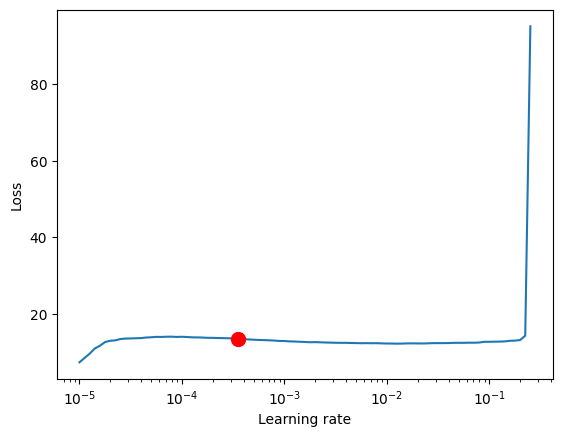

In [ ]:
# find optimal learning rate
res = trainer.tuner.lr_find(net, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 2.0 M 
-----------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.180     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

AttributeError: 'ExperimentWriter' object has no attribute 'add_figure'

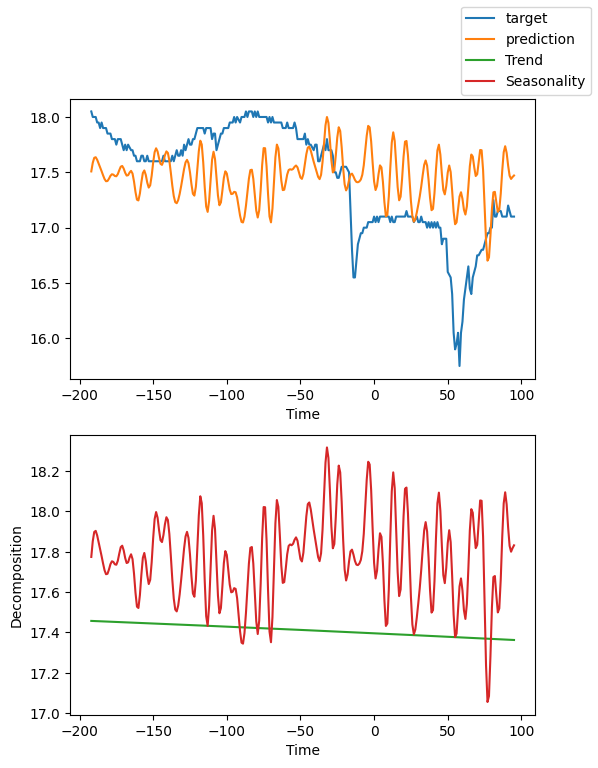

In [ ]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=100,
    gpus=0,
    enable_model_summary=True,
    gradient_clip_val=0.01,
    callbacks=[early_stop_callback],
    limit_train_batches=30,
)


net = NBeats.from_dataset(
    training,
    learning_rate=3.5e-4,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    widths=[32, 512],
    backcast_loss_ratio=1.0,
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)